In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LocallyConnected1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
timesteps = 1440
input_dim = 1
n_epochs = 100
batch_size = 32
drop_rate = 0.8
n_samples = 6000

In [4]:
# load real-world time series trading data
def load_data(symbol):
    
    ROOT = os.path.join(r'C:\Users\vhuang\Desktop\Hazelnut', 'datasets')
    allfiles = glob.glob(os.path.join(ROOT, symbol, '*.csv'))
    n_samples = np.size(allfiles)
    
    data = np.zeros((n_samples, timesteps, input_dim))
    for i, file in enumerate(allfiles):
        df = pd.read_csv(file, usecols=[4])
        if df.values.shape[0] != timesteps:
            print(file)
            print(i + ' missing rows')
        else:
            data[i] = df.values
    
    return data

In [5]:
symbol_list = ['kiwi']
# symbol_list = ['apple', 'banana', 'cherry', 'grape', 'kiwi', 'orange']
data_dict = {}

for symbol in symbol_list:
    data_dict[symbol] = load_data(symbol)

In [6]:
def train_test_split(data):
    # training set is 0.8 of the total
    test_split = int(data.shape[0]*0.8)
    X_train_full = data[:test_split]
    X_test = data[test_split:]
    # validation set is 0.1 of the training
    valid_split = int(test_split*0.9)
    X_train = X_train_full[:valid_split]
    X_valid = X_train_full[valid_split:]
    
    return X_train, X_test, X_valid

In [7]:
RawData = data_dict['kiwi'].copy()

X_train, X_test, X_valid = train_test_split(RawData)

In [8]:
def preprocess(data):
    for i in range(data.shape[0]):
        scaler = StandardScaler()
        data[i] = scaler.fit_transform(data[i])
        
    return data

In [9]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3866, 1440, 1)
(1075, 1440, 1)
(430, 1440, 1)


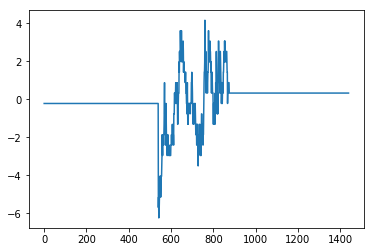

In [11]:
plt.plot(X_train[100])

In [12]:
# Convolutional Autoencoder

In [13]:
# input sequence
input_seq = Input(shape=(timesteps, input_dim))

# encoder with Conv1D and MaxPooling1D
X = Conv1D(filters=4, kernel_size=3, strides=1, padding='causal', activation='relu')(input_seq)
X = BatchNormalization()(X)
X = MaxPooling1D(6, padding='valid')(X)

X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling1D(6, padding='valid')(X)

X = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
encoded = MaxPooling1D(4, padding='valid')(X)

In [14]:
# decoder with Conv1D and UpSampling1D
X = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu')(encoded)
X = BatchNormalization()(X)
X = UpSampling1D(4)(X)

X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(6)(X)

X = Conv1D(filters=4, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(6)(X)
decoded = Conv1D(filters=1, kernel_size=3, strides=1, padding='causal', activation='sigmoid')(X)

In [15]:
Conv1DAuto_Simulation = Model(inputs=[input_seq], outputs=[decoded])

In [16]:
Conv1DAuto_Real = clone_model(Conv1DAuto_Simulation)

In [17]:
Conv1DAuto_Simulation.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1440, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1440, 4)           16        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 1440, 4)           16        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 240, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 240, 8)            104       
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 240, 8)            32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 8)             0     

In [18]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_Real.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [19]:
Conv1DAuto_Real.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [20]:
history_real = Conv1DAuto_Real.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid))

Train on 3866 samples, validate on 430 samples
Epoch 1/100
3866/3866 [==============================] - 10s 3ms/sample - loss: 0.7626 - mse: 0.7626 - val_loss: 0.7415 - val_mse: 0.7415
Epoch 2/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.6233 - mse: 0.6233 - val_loss: 0.6446 - val_mse: 0.6446
Epoch 3/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.6052 - mse: 0.6052 - val_loss: 0.6243 - val_mse: 0.6243
Epoch 4/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5970 - mse: 0.5970 - val_loss: 0.6193 - val_mse: 0.6193
Epoch 5/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5920 - mse: 0.5920 - val_loss: 0.6160 - val_mse: 0.6160
Epoch 6/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5887 - mse: 0.5887 - val_loss: 0.6138 - val_mse: 0.6138
Epoch 7/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5863 - mse: 0.5863 - val_loss: 0.6111 - val_mse: 

3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5706 - mse: 0.5706 - val_loss: 0.5908 - val_mse: 0.5908
Epoch 61/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5705 - mse: 0.5705 - val_loss: 0.5907 - val_mse: 0.5907
Epoch 62/100
3866/3866 [==============================] - 6s 2ms/sample - loss: 0.5705 - mse: 0.5705 - val_loss: 0.5908 - val_mse: 0.5908
Epoch 63/100
3866/3866 [==============================] - 6s 2ms/sample - loss: 0.5704 - mse: 0.5704 - val_loss: 0.5908 - val_mse: 0.5908
Epoch 64/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5706 - mse: 0.5706 - val_loss: 0.5906 - val_mse: 0.5906
Epoch 65/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5706 - mse: 0.5706 - val_loss: 0.5905 - val_mse: 0.5905
Epoch 66/100
3866/3866 [==============================] - 7s 2ms/sample - loss: 0.5703 - mse: 0.5703 - val_loss: 0.5904 - val_mse: 0.5904
Epoch 67/100
3866/3866 [=======================

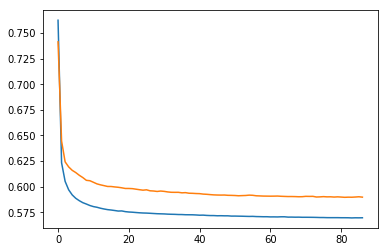

In [21]:
plt.plot(history_real.history['loss'])
plt.plot(history_real.history['val_loss'])

In [22]:
X_pred = Conv1DAuto_Real.predict(X_test)

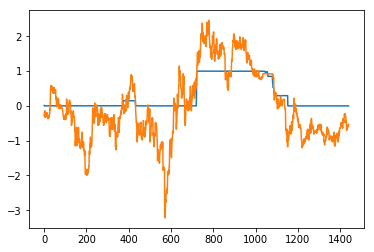

In [23]:
plt.plot(X_pred[500])
plt.plot(X_test[500])

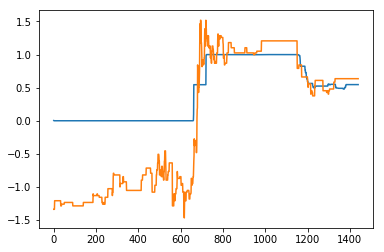

In [24]:
plt.plot(X_pred[50])
plt.plot(X_test[50])

In [25]:
# generate simulation sequence using trigonometric functions
x = np.linspace(0, 1, timesteps)
X = np.zeros((n_samples, timesteps, 1))

for i in range(n_samples):
    z = np.random.normal()
    a = np.random.random()*10
    b = np.random.random()*5
    y = np.sin(2*np.pi*a*x) + z*10*np.sin(2*np.pi*b*x)
    X[i] = y.reshape(timesteps, 1)

In [26]:
X_train = X[:4000]
X_test = X[4500:]
X_valid = X[4000:4500]

In [27]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(4000, 1440, 1)
(1500, 1440, 1)
(500, 1440, 1)


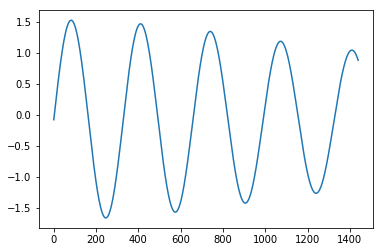

In [29]:
plt.plot(X_train[100])

In [30]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_Simulation.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [31]:
Conv1DAuto_Simulation.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [32]:
history_simulation = Conv1DAuto_Simulation.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid))

Train on 4000 samples, validate on 500 samples
Epoch 1/100
4000/4000 [==============================] - 10s 2ms/sample - loss: 0.7704 - mse: 0.7704 - val_loss: 0.8285 - val_mse: 0.8285
Epoch 2/100
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.6169 - mse: 0.6169 - val_loss: 0.7280 - val_mse: 0.7280
Epoch 3/100
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.5917 - mse: 0.5917 - val_loss: 0.6144 - val_mse: 0.6144
Epoch 4/100
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.5811 - mse: 0.5811 - val_loss: 0.5856 - val_mse: 0.5856
Epoch 5/100
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.5752 - mse: 0.5752 - val_loss: 0.5748 - val_mse: 0.5748
Epoch 6/100
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.5713 - mse: 0.5713 - val_loss: 0.5732 - val_mse: 0.5732
Epoch 7/100
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.5682 - mse: 0.5682 - val_loss: 0.5716 - val_mse: 

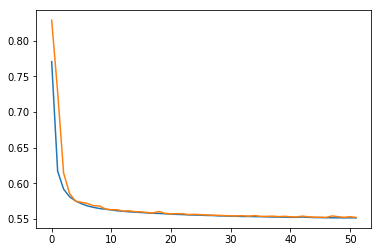

In [33]:
plt.plot(history_simulation.history['loss'])
plt.plot(history_simulation.history['val_loss'])

In [34]:
X_pred = Conv1DAuto_Simulation.predict(X_test)

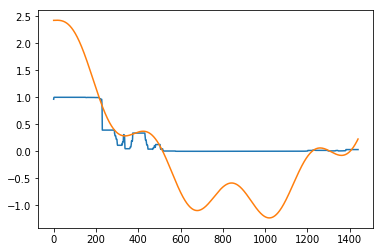

In [35]:
plt.plot(X_pred[500])
plt.plot(X_test[500])

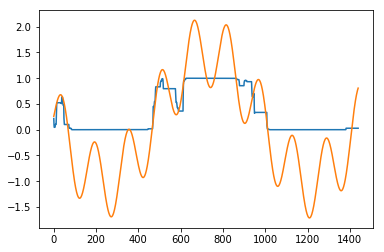

In [36]:
plt.plot(X_pred[501])
plt.plot(X_test[501])

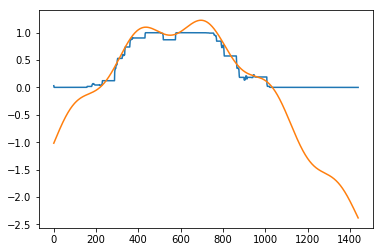

In [37]:
plt.plot(X_pred[400])
plt.plot(X_test[400])